**Purpose**

The purpose of this notebook is to process proteins from many strains of individual species so that they can all be screened for mucinase domains by dbCan Meta, then to process those results so the prevalence of those proteins within the species can be calculated.

In [1]:
# Import the tools and functions necessary to perform the analysis
from dida_utils import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Functions necessary to run analysis

# This function condenses the protein sequences from isolates across multiple .faa files and condenses them into a single .fasta file, retaining which strains are associated with each protein
# faaFolder: Path to the folder containing the faa files to condense. These should all be from a single species.
# outputPath: Path where the condensed file should be written. This should include the name of the file, i.e. "C:/Users/emlee/Documents/Lactobacillus_crispatus.fasta"
# Note: The .faa files to condense must all be named in the format "Genus_species_strain.faa". The condensed file will only carry over the strain and ID information.
def condenseNCBIFiles(faaFolder, outputPath):
    proteinDict = {} #key=amino acid sequence, value=SimpleProtein object
    for file in faaFolder.iterdir():
        if file.suffix == '.faa':
            namestring = file.stem
            if namestring.count('_') != 2:
                raise Exception(f'Error: The name of file {file.name} is not formatted properly. Files must have 2 "_" characters to properly determine genus, species, and strain.')
            if namestring.find('.') != -1:
                raise Exception(f'Error: The name of file {file.name} has an extra "." character, which will interfere with determining genus, species, and strain. Rename the file.')
            nameList = namestring.split('_')
            with open(file, 'r') as database:
                rawText = database.read()
                dataList = rawText.split('\n>')
                dataList[0] = dataList[0][1:]
                del rawText
                for sequence in dataList:
                    newProt = SimpleProtein(sequence)
                    if not newProt.sequence in proteinDict.keys():
                        proteinDict[newProt.sequence] = newProt
                    proteinDict[newProt.sequence].addStrain(nameList[2])
    toWrite = []
    for protein in proteinDict.values():
        toWrite.append(protein.getEntry())
    with open(outputPath, 'w', newline='') as outfile:
        outfile.write(''.join(toWrite))
        
# This function loads the contents of a condensed .fasta file into python so it can be used to analyze against dbCan Meta results
# Returns: A dictionary in the format {key=protein ID, value=list of strains that have the protein}
# condensedFile: An output file from the condenseNCBIFiles() function
def processCondensedFile(condensedFile):
    toReturn = {} #key=protein ID, value=list of strains with the protein
    with open(condensedFile, 'r') as database:
        rawText = database.read()
        dataList = rawText.split('\n>')
        dataList[0] = dataList[0][1:]
        del rawText
        for sequence in dataList:
            newProt = SimpleProtein(sequence, initWithStrains=True)
            toReturn[newProt.id] = newProt
    return toReturn

# Returns: A list in the format ['GH1', 'GH33', ...]
# hmmerString: String of the hmmer output generated by dbCan Meta
def getGHFamilies(hmmerString):
    toReturn = []
    stringStart = hmmerString.find('GH') + 2
    if stringStart == -1:
        return toReturn
    stringEnd = hmmerString.find('(', stringStart)
    nums = hmmerString[stringStart:stringEnd].split('_')
    for num in nums:
        toReturn.append('GH' + num)
    return toReturn

# Generates a .csv file showing the cazymes with a signal peptide for each bacterial strain
# condensedProteins: Output from the processCondensedFile() function
# dbCanOutput: Output from the pd.read_csv() function of a dbCan Meta analysis
# cazymes: A list of the cazyme families to screen for in the format ['GH29', 'GH33', etc]
# outputPath: Path where the report should be written. This should include the name of the file, i.e. "C:/Users/emlee/Documents/Lactobacillus_crispatus_report.csv"
# Note, if the organism doesn't have any of the specified cazymes, the report will be empty except for headers
def generateSecretedCazymeReport(condensedProteins, dbCanOutput, cazymes, outputPath):
    strainDict = {} #key=strain, value=list of tuples in the format [(protein ID, HMMER output), ...]
    for index, row in dbCanOutput.iterrows():
        if row['Signalp'].find('Y') != -1:
            ghs = getGHFamilies(row['HMMER'])
            proteinAdded = False
            for family in ghs:
                if family in cazymes and proteinAdded == False:
                    proteinAdded = True
                    strains = condensedProteins[row['Gene ID']].strains
                    for strain in strains:
                        if not strain in strainDict.keys():
                            strainDict[strain] = []
                        strainDict[strain].append((row['Gene ID'], row['HMMER']))
    output = {'Strain':[], 'Protein':[], 'HMMER Output':[]}
    for strain, protList in strainDict.items():
        for pair in protList:
            output['Strain'].append(strain)
            output['Protein'].append(pair[0])
            output['HMMER Output'].append(pair[1])
    pd.DataFrame(output).to_csv(outputPath)

In [3]:
# Set up the main analysis folder that holds all the species sequence folders
analysisPath = Path.cwd().joinpath('analysis_files/strain_analysis/')
figPath = Path.cwd().joinpath('figures/strain_mucinases_analysis/')

In [4]:
# This code reads through all of the .faa protein files in the folder: files/strain_analysis/Lactobacillus_mulieris/
# It then condenses the proteins from all those files into a single .fasta file named "Lactobacillus_mulieris.fasta"
#LmulierisFile = analysisPath.joinpath('Lactobacillus_mulieris/Lactobacillus_mulieris.fasta')
#condenseNCBIFiles(analysisPath.joinpath('Lactobacillus_mulieris/'), LmulierisFile)
# The Hoylesella_timonensis file can then be submitted to dbCan Meta to screen all Hoylesella timonensis proteins for cazyme domains

In [5]:
# This code loads the condensed L. mulieris proteins back into python
#LmulierisProteins = processCondensedFile(LmulierisFile)

In [6]:
# This code loads the output from dbCan Meta of searching all H. timonensis proteins
# This example assumes you have run the dbCan Meta analysis and named the result file "Hoylesella_timonensis_cazymes.tsv" and saved it in the /files/strain_analysis/Hoylesella_timonensis/ folder
#LmulierisCazymes = pd.read_csv(analysisPath.joinpath('Lactobacillus_mulieris/Lactobacillus_mulieris_cazymes.tsv'), sep='\t')

In [7]:
# This code creates a report of the secreted mucinases for L. mulieris and writes it out to a new .csv file
#generateSecretedCazymeReport(LmulierisProteins,LmulierisCazymes, mucinases, analysisPath.joinpath('Lactobacillus_mulieris/Lactobacillus_mulieris_mucinase_report.csv'))

In [8]:
# Initialize the list of GH families involved in mucin degradation
mucinases = ['GH2', 'GH20', 'GH29', 'GH33', 'GH35', 'GH84', 'GH85', 'GH95', 'GH101']

In [9]:
# Initialize a list of bacteria with mucinase enzymes
species = ['Arcanobacterium haemolyticum', 'Gardnerella pickettii', 'Gardnerella piotii', 'Hoylesella timonensis', 'Prevotella amnii', 'Prevotella bivia', 'Anaerococcus vaginalis', 'Peptoniphilus lacrimalis']

In [10]:
speciesDir = {} #key=species name, value={'GH2':[list of counts in each isolate genome], ...}
for x in analysisPath.iterdir():
    if str(x).find('_') != -1:
        folderSpecies = str(x.name).replace('_', ' ')
        if folderSpecies in species:
            isolateCount = 0
            for y in x.iterdir():
                if os.path.isdir(y):
                    isolateCount += 1
            speciesDir[folderSpecies] = {}
            for gh in mucinases:
                speciesDir[folderSpecies][gh] = []
            df = pd.read_csv(x.joinpath(f'{x.name}_mucinase_report.csv'))
            isFirst = True
            currentStrain = None
            counts = {} #key=Gh family, value=[list of counts for a single strain]
            for mucinase in mucinases:
                counts[mucinase] = 0
            for index, row in df.iterrows():
                if isFirst:
                    currentStrain = row['Strain']
                    isFirst = False
                if row['Strain'] != currentStrain:
                    for mucinase, count in counts.items():
                        speciesDir[folderSpecies][mucinase].append(count)
                    counts = {}
                    currentStrain = row['Strain']
                    for mucinase in mucinases:
                        counts[mucinase] = 0
                for gh in getGHFamilies(row['HMMER Output']):
                    if gh in mucinases:
                        counts[gh] += 1
            for mucinase, count in counts.items():
                speciesDir[folderSpecies][mucinase].append(count)
            strainsWithoutMucinases = isolateCount - len(speciesDir[folderSpecies][mucinase])
            for i in range(strainsWithoutMucinases):
                for gh in mucinases:
                    speciesDir[folderSpecies][gh].append(0)

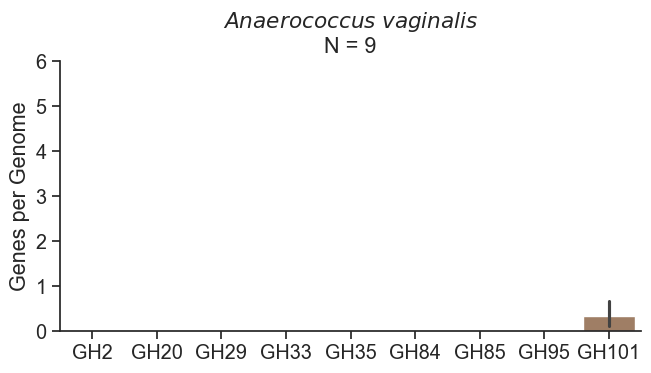

In [11]:
toPlot = {'GH':[], 'Copy Number':[]}
df = pd.DataFrame(speciesDir['Anaerococcus vaginalis'])
for gh in mucinases:
    for value in df[gh].tolist():
        toPlot['GH'].append(gh)
        toPlot['Copy Number'].append(value)
fig, ax = plt.subplots(figsize=(7.5, 3.5))
plot = sns.barplot(ax=ax, data=pd.DataFrame(toPlot), x='GH', y='Copy Number', palette=['#9163C1', '#DA1919', '#FF76D7', '#44A043', '#9163C1', '#DA1919', '#DA1919', '#FF76D7', '#A87D5C'])
n = f'\nN = {str(len(df))}'
plot.set(title='$\it{Anaerococcus}$ $\it{vaginalis}$' + n, ylabel='Genes per Genome', xlabel='', ylim=(0, 6))
sns.despine()
#saveFig(plot, figPath.joinpath('Avaginalis.png'))

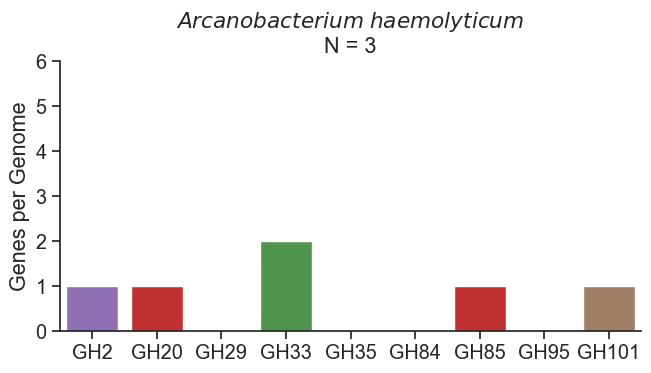

In [12]:
toPlot = {'GH':[], 'Copy Number':[]}
df = pd.DataFrame(speciesDir['Arcanobacterium haemolyticum'])
for gh in mucinases:
    for value in df[gh].tolist():
        toPlot['GH'].append(gh)
        toPlot['Copy Number'].append(value)
fig, ax = plt.subplots(figsize=(7.5, 3.5))
plot = sns.barplot(ax=ax, data=pd.DataFrame(toPlot), x='GH', y='Copy Number', palette=['#9163C1', '#DA1919', '#FF76D7', '#44A043', '#9163C1', '#DA1919', '#DA1919', '#FF76D7', '#A87D5C'])
n = f'\nN = {str(len(df))}'
plot.set(title='$\it{Arcanobacterium}$ $\it{haemolyticum}$' + n, ylabel='Genes per Genome', xlabel='', ylim=(0, 6))
sns.despine()
#saveFig(plot, figPath.joinpath('Ahaemolyticum.png'))

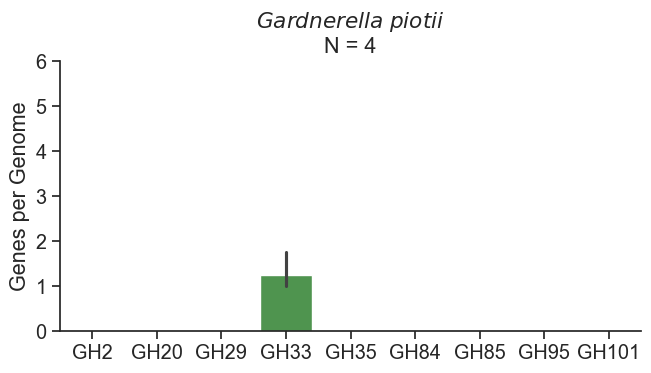

In [13]:
toPlot = {'GH':[], 'Copy Number':[]}
df = pd.DataFrame(speciesDir['Gardnerella piotii'])
for gh in mucinases:
    for value in df[gh].tolist():
        toPlot['GH'].append(gh)
        toPlot['Copy Number'].append(value)
fig, ax = plt.subplots(figsize=(7.5, 3.5))
plot = sns.barplot(ax=ax, data=pd.DataFrame(toPlot), x='GH', y='Copy Number', palette=['#9163C1', '#DA1919', '#FF76D7', '#44A043', '#9163C1', '#DA1919', '#DA1919', '#FF76D7', '#A87D5C'])
n = f'\nN = {str(len(df))}'
plot.set(title='$\it{Gardnerella}$ $\it{piotii}$' + n, ylabel='Genes per Genome', xlabel='', ylim=(0, 6))
sns.despine()
#saveFig(plot, figPath.joinpath('Gpiotii.png'))

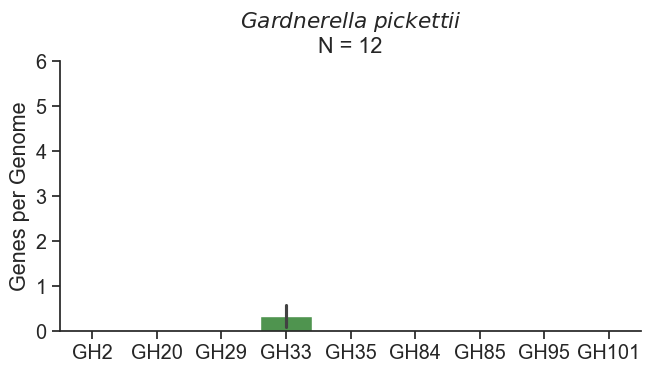

In [14]:
toPlot = {'GH':[], 'Copy Number':[]}
df = pd.DataFrame(speciesDir['Gardnerella pickettii'])
for gh in mucinases:
    for value in df[gh].tolist():
        toPlot['GH'].append(gh)
        toPlot['Copy Number'].append(value)
fig, ax = plt.subplots(figsize=(7.5, 3.5))
plot = sns.barplot(ax=ax, data=pd.DataFrame(toPlot), x='GH', y='Copy Number', palette=['#9163C1', '#DA1919', '#FF76D7', '#44A043', '#9163C1', '#DA1919', '#DA1919', '#FF76D7', '#A87D5C'])
n = f'\nN = {str(len(df))}'
plot.set(title='$\it{Gardnerella}$ $\it{pickettii}$' + n, ylabel='Genes per Genome', xlabel='', ylim=(0, 6))
sns.despine()
#saveFig(plot, figPath.joinpath('Gpickettii.png'))

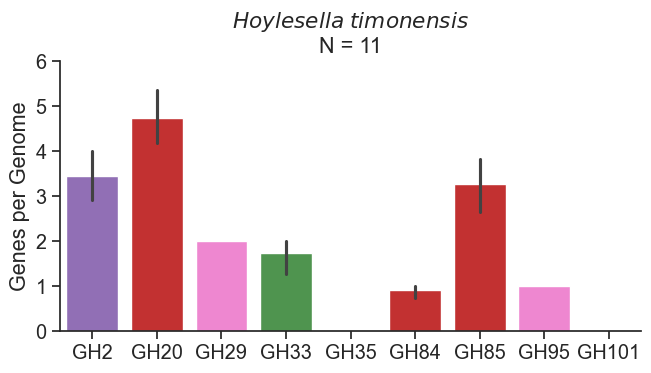

In [15]:
toPlot = {'GH':[], 'Copy Number':[]}
df = pd.DataFrame(speciesDir['Hoylesella timonensis'])
for gh in mucinases:
    for value in df[gh].tolist():
        toPlot['GH'].append(gh)
        toPlot['Copy Number'].append(value)
fig, ax = plt.subplots(figsize=(7.5, 3.5))
plot = sns.barplot(ax=ax, data=pd.DataFrame(toPlot), x='GH', y='Copy Number', palette=['#9163C1', '#DA1919', '#FF76D7', '#44A043', '#9163C1', '#DA1919', '#DA1919', '#FF76D7', '#A87D5C'])
n = f'\nN = {str(len(df))}'
plot.set(title='$\it{Hoylesella}$ $\it{timonensis}$' + n, ylabel='Genes per Genome', xlabel='', ylim=(0, 6))
sns.despine()
#saveFig(plot, figPath.joinpath('Htimonensis.png'))

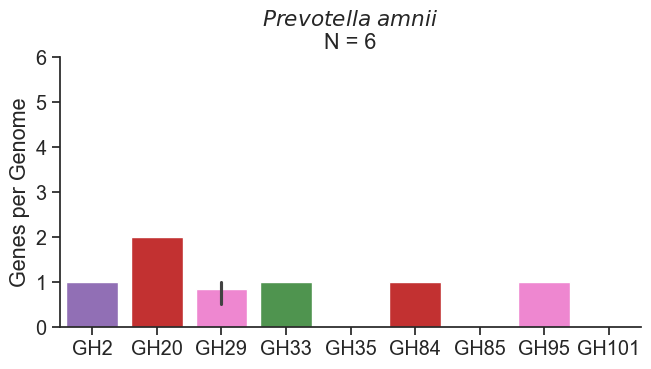

In [16]:
toPlot = {'GH':[], 'Copy Number':[]}
df = pd.DataFrame(speciesDir['Prevotella amnii'])
for gh in mucinases:
    for value in df[gh].tolist():
        toPlot['GH'].append(gh)
        toPlot['Copy Number'].append(value)
fig, ax = plt.subplots(figsize=(7.5, 3.5))
plot = sns.barplot(ax=ax, data=pd.DataFrame(toPlot), x='GH', y='Copy Number', palette=['#9163C1', '#DA1919', '#FF76D7', '#44A043', '#9163C1', '#DA1919', '#DA1919', '#FF76D7', '#A87D5C'])
n = f'\nN = {str(len(df))}'
plot.set(title='$\it{Prevotella}$ $\it{amnii}$' + n, ylabel='Genes per Genome', xlabel='', ylim=(0, 6))
sns.despine()
#saveFig(plot, figPath.joinpath('Pamnii.png'))

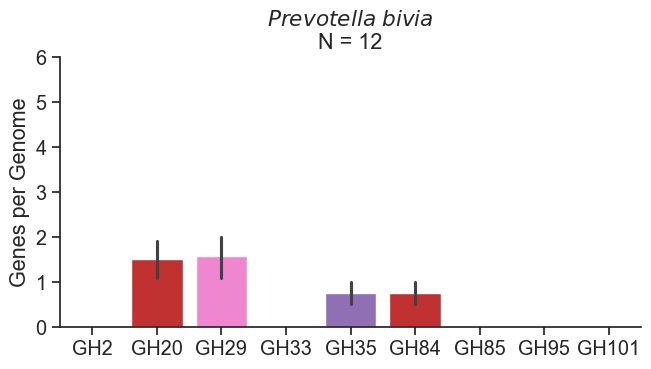

In [17]:
toPlot = {'GH':[], 'Copy Number':[]}
df = pd.DataFrame(speciesDir['Prevotella bivia'])
for gh in mucinases:
    for value in df[gh].tolist():
        toPlot['GH'].append(gh)
        toPlot['Copy Number'].append(value)
fig, ax = plt.subplots(figsize=(7.5, 3.5))
plot = sns.barplot(ax=ax, data=pd.DataFrame(toPlot), x='GH', y='Copy Number', palette=['#9163C1', '#DA1919', '#FF76D7', '#44A043', '#9163C1', '#DA1919', '#DA1919', '#FF76D7', '#A87D5C'])
n = f'\nN = {str(len(df))}'
plot.set(title='$\it{Prevotella}$ $\it{bivia}$' + n, ylabel='Genes per Genome', xlabel='', ylim=(0, 6))
sns.despine()
#saveFig(plot, figPath.joinpath('Pbivia.png'))

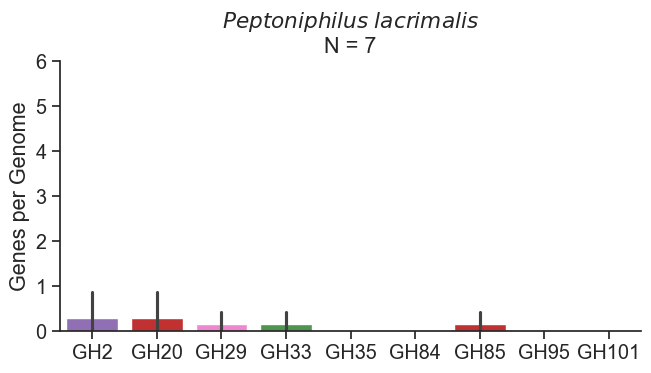

In [18]:
toPlot = {'GH':[], 'Copy Number':[]}
df = pd.DataFrame(speciesDir['Peptoniphilus lacrimalis'])
for gh in mucinases:
    for value in df[gh].tolist():
        toPlot['GH'].append(gh)
        toPlot['Copy Number'].append(value)
fig, ax = plt.subplots(figsize=(7.5, 3.5))
plot = sns.barplot(ax=ax, data=pd.DataFrame(toPlot), x='GH', y='Copy Number', palette=['#9163C1', '#DA1919', '#FF76D7', '#44A043', '#9163C1', '#DA1919', '#DA1919', '#FF76D7', '#A87D5C'])
n = f'\nN = {str(len(df))}'
plot.set(title='$\it{Peptoniphilus}$ $\it{lacrimalis}$' + n, ylabel='Genes per Genome', xlabel='', ylim=(0, 6))
sns.despine()
#saveFig(plot, figPath.joinpath('Placrimalis.png'))